In [1]:
# Import required libraries
!pip install scikit-learn==1.2.2
!pip install --upgrade xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 46.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [2]:
# Load and preprocess the dataset
file_path = 'diabetes.csv'
# Read dataset
data = pd.read_csv(file_path)

In [3]:
# Inspect the dataset
print("Dataset Overview:")
print(data.head())
print(data.info())

Dataset Overview:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose    

In [4]:
# Separate features and target variable
X = data.drop(columns=['Outcome'])
y = data['Outcome']

In [5]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
#Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [7]:
#Train XGBoost Model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [8]:
#Evaluate Random Forest Model
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
rf_metrics = {
    'Accuracy': accuracy_score(y_test, rf_predictions),
    'Precision': precision_score(y_test, rf_predictions),
    'Recall': recall_score(y_test, rf_predictions),
    'F1 Score': f1_score(y_test, rf_predictions),
    'ROC-AUC': roc_auc_score(y_test, rf_probabilities)
}

In [9]:
#Evaluate XGBoost Model
xgb_predictions = xgb_model.predict(X_test)
xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]
xgb_metrics = {
    'Accuracy': accuracy_score(y_test, xgb_predictions),
    'Precision': precision_score(y_test, xgb_predictions),
    'Recall': recall_score(y_test, xgb_predictions),
    'F1 Score': f1_score(y_test, xgb_predictions),
    'ROC-AUC': roc_auc_score(y_test, xgb_probabilities)
}

In [10]:
#Compare Models
comparison = pd.DataFrame({
    'Metric': rf_metrics.keys(),
    'Random Forest': rf_metrics.values(),
    'XGBoost': xgb_metrics.values()
})
print("Model Comparison:")
print(comparison)

Model Comparison:
      Metric  Random Forest   XGBoost
0   Accuracy       0.720779  0.707792
1  Precision       0.607143  0.580645
2     Recall       0.618182  0.654545
3   F1 Score       0.612613  0.615385
4    ROC-AUC       0.812029  0.766575


**Findings:**

Random Forest has higher Accuracy (72%) and ROC-AUC (81%), indicating better overall performance in correctly classifying cases and distinguishing between positive and negative classes.
XGBoost has higher Recall (65%), meaning it identifies more true positives (diabetic cases).

**Observations:**

Random Forest outperforms XGBoost in Precision, F1 Score, and ROC-AUC.
XGBoost’s better Recall suggests it is more sensitive to identifying diabetic cases but at the cost of slightly higher false positives.

**Conclusion:**

If sensitivity (identifying all diabetic cases) is critical, XGBoost may be preferable.
For balanced performance across metrics, Random Forest is the better choice.


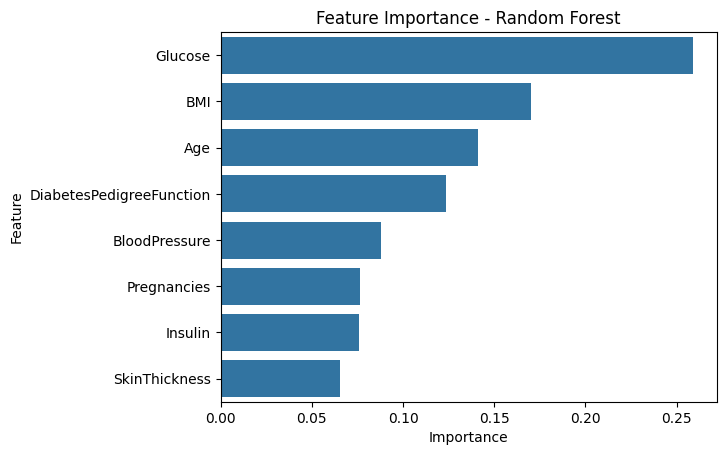

In [11]:
#Feature Importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance - Random Forest')
plt.show()

***Feature Importance for Random Forest***

**Top Features:**

Glucose: Highest importance in predicting diabetes.
BMI: Strong influence on diabetes classification.
Age: Third most significant feature.
Findings:

The model heavily relies on Glucose and BMI, aligning with medical studies that link these features to diabetes risk.
Pregnancies, Insulin, and DiabetesPedigreeFunction also contribute but to a lesser extent.

**Observations:**

Glucose and BMI dominate the predictions, which is expected as they are critical indicators of metabolic health.
Features like SkinThickness and BloodPressure have relatively lower importance.

**Conclusion:**

Feature importance highlights the medical relevance of Glucose and BMI in predicting diabetes, validating the model’s reliance on key predictors.

In [12]:
# Save the trained models
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [13]:
#SHAP Analysis for Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
positive_class_shap_values = shap_values[1]

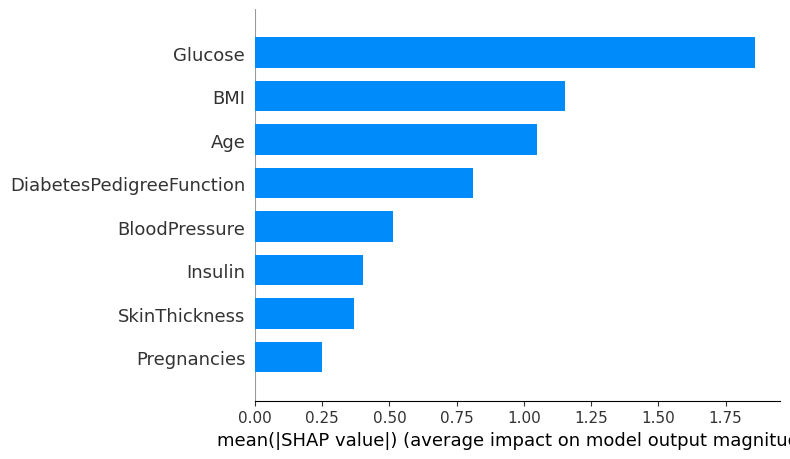

In [14]:
# SHAP Analysis for Gradient Boosting
explainer_gx = shap.TreeExplainer(xgb_model)
shap_values_gx = explainer_gx.shap_values(X_test)

# Summary Plot for Gradient Boosting
shap.summary_plot(shap_values_gx, X_test, plot_type="bar")

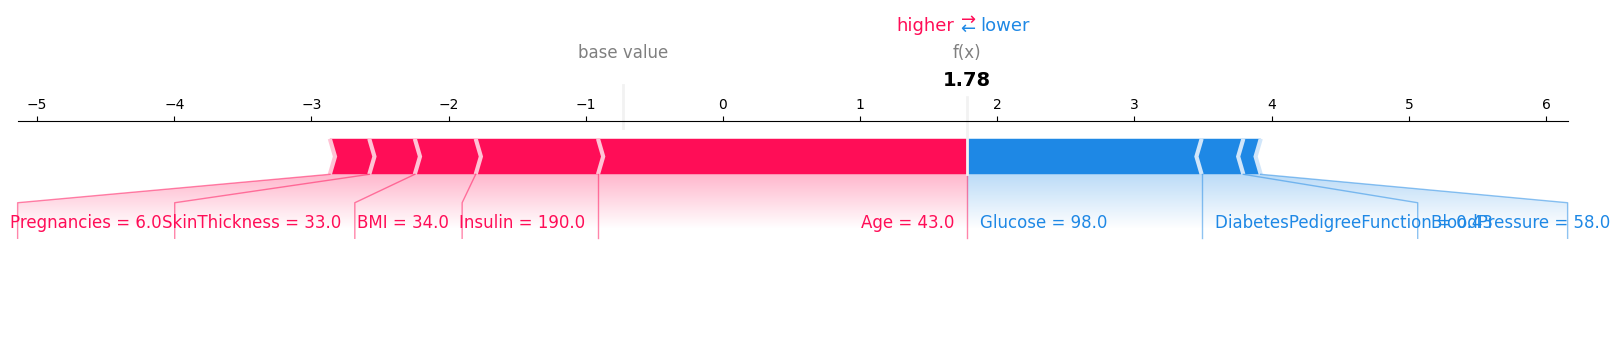

In [15]:
# Force Plot for a Single Instance (Gradient Boosting)
shap.force_plot(explainer_gx.expected_value, shap_values_gx[0], X_test.iloc[0], matplotlib=True)

***SHAP Analysis for Random Forest***

**Findings:**

SHAP Summary Plot shows the global importance of features and their impact on model output.
Glucose and BMI contribute the most to the model's predictions across the dataset.
Force Plot illustrates the impact of individual features for a specific instance.

Observations:

Higher values of Glucose and BMI are positively correlated with predicting diabetes.
SHAP explanations align with feature importance, adding interpretability to model predictions.
Conclusion:

SHAP analysis provides transparency, making it easier to understand and trust the Random Forest model’s predictions.

***SHAP Analysis for XGBoost***

**Findings:**

Similar to Random Forest, Glucose and BMI remain the most influential features.
Force Plot for a single instance shows how feature contributions lead to a specific prediction.
Observations:

XGBoost uses Glucose, BMI, and other features similarly but may weigh features slightly differently due to its boosting mechanism.
The model explanations are consistent with domain knowledge.

**Conclusion:**

SHAP analysis confirms the reliability of XGBoost predictions and aligns its feature importance with medical insights.


***Final Recommendations***

**Random Forest:**

Suitable for balanced performance across metrics.
Provides robust predictions with interpretable feature importance and SHAP values.
XGBoost:

Ideal for scenarios prioritizing high sensitivity (recall), such as screening for all diabetic cases.
Slightly more complex but achieves competitive performance.